In [2]:

import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import os
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
#drive.mount("/content/gdrive", force_remount=True)

In [2]:
import torch
print(torch.cuda.is_available())

True


C:\Users\alanf\AppData\Local\Temp\cuda

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device
print("Is CUDA supported by this system?",{torch.cuda.is_available()})
print("CUDA version: {torch.version.cuda}")
 
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print("ID of current CUDA device:",{torch.cuda.current_device()})
       
print("Name of current CUDA device:",{torch.cuda.get_device_name(cuda_id)})

Is CUDA supported by this system? {True}
CUDA version: {torch.version.cuda}
ID of current CUDA device: {0}
Name of current CUDA device: {'NVIDIA GeForce RTX 3060'}


# DATA PROCESSING

In [5]:
import os
print(os.getcwd())

c:\Users\alanf\Desktop\aps360project


In [10]:
mean = torch.tensor([0.1152,0.1152,0.1152])
std = torch.tensor([0.1977,0.1977,0.1977])
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,std=std)])
criterion = nn.CrossEntropyLoss()
train_path = 'c:\\Users\\alanf\\Desktop\\aps360project\\ProjectSplits1400\\Training'
train_set = torchvision.datasets.ImageFolder(root = train_path, transform = transform)

valid_path = 'c:\\Users\\alanf\\Desktop\\aps360project\\ProjectSplits1400\\Validation'
valid_set = torchvision.datasets.ImageFolder(root = valid_path, transform = transform)


test_path = 'c:\\Users\\alanf\\Desktop\\aps360project\\ProjectSplits1400\\Testing'
test_set = torchvision.datasets.ImageFolder(root = test_path, transform = transform)

# test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)

# Model

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5, 1, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 12, 3, 1, 2)
        self.fc1 = nn.Linear(12 * 57 * 57, 32)
        self.fc2 = nn.Linear(32, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 12 * 57 * 57)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class StackedModel(nn.Module):
    def __init__(self):
        super(StackedModel, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        self.googlenet = models.googlenet(pretrained=True)
        self.baseline = BaselineModel()

        num_features_resnet50 = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(num_features_resnet50, 5)

        num_features_googlenet = self.googlenet.fc.in_features
        self.googlenet.fc = nn.Linear(num_features_googlenet, 5)


        # # Replace the last layer of ResNet50 and Inception with identity, since we're not using their original classification layers
        # self.resnet50.fc = nn.Identity()
        # self.inception.fc = nn.Identity()

    def forward(self, x):
        # Assuming x is the input tensor
        resnet_output = self.resnet50(x)
        googlenet_output = self.googlenet(x)
        baseline_output = self.baseline(x)

        # Average the outputs
        averaged_output = (resnet_output + googlenet_output + baseline_output) / 3
        return averaged_output

# Create the stacked model
model = StackedModel()

# Example input tensor (replace with actual image tensor)
input_tensor = torch.randn(1, 3, 224, 224)  # Batch size 1, 3 color channels, 224x224 image

# Get the output
output = model(input_tensor)
print(output)

c:\Users\alanf\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alanf\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\alanf\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights

tensor([[ 0.0596,  0.0665,  0.1211, -0.0288, -0.1203]], grad_fn=<DivBackward0>)


# Helper Functions

In [4]:
def get_model_name(name, batch_size, lr, num_epochs):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_num_epoch{3}".format(name,
                                                   batch_size,
                                                   lr,
                                                   num_epochs)
    return path

In [5]:
def plot_all_confusion_matrices(confusion_matrices, classes, set_title='Training', cmap=plt.cm.Blues):
    num_epochs = len(confusion_matrices)
    fig, axes = plt.subplots(nrows=1, ncols=num_epochs, figsize=(num_epochs * 5, 4), sharey=True)

    for idx, cm in enumerate(confusion_matrices):
        ax = axes[idx]
        sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=ax)
        ax.set_title(f'Epoch {idx+1}')
        ax.set_xlabel('Predicted Label')
        if idx == 0:
            ax.set_ylabel('True Label')
        ax.set_xticklabels(classes, rotation=45)
        ax.set_yticklabels(classes, rotation=45)

    plt.suptitle(f'{set_title} Confusion Matrices Over Epochs')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [6]:
def plot_last_confusion_matrix(confusion_matrix, classes, set_title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap=cmap)
    plt.title(f'{set_title} - Last Epoch')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(np.arange(len(classes)), classes, rotation=45)
    plt.yticks(np.arange(len(classes)), classes, rotation=45)
    plt.show()

In [7]:
def get_accuracy(model, data_loader, device, return_cm=False):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for imgs, labels in data_loader:
            if torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            #imgs, labels = imgs.to(device), labels.to(device)
            output = model(imgs)
            _, predicted = torch.max(output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = correct / total
    if return_cm:
        cm = confusion_matrix(all_labels, all_preds)
        return accuracy, cm

    return accuracy

In [8]:
def train(model, train_set, val_set, batch_size=64, num_epochs=10, lr=0.001):
    torch.manual_seed(10)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr)
    # To store confusion matrices
    all_train_cm = []
    all_val_cm = []

    train_acc, val_acc = [], []
    epochs = np.arange(1, num_epochs + 1)

    for epoch in range(num_epochs):
        model.train()
        for imgs, labels in train_loader:
            if True and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            # imgs, labels = imgs.to(device), labels.to(device)

            # Forward pass
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Calculate accuracy on training and validation set
        train_accuracy, train_cm = get_accuracy(model, train_loader, device, return_cm=True)
        val_accuracy, val_cm = get_accuracy(model, val_loader, device, return_cm=True)
        all_train_cm.append(train_cm)
        all_val_cm.append(val_cm)

        train_acc.append(train_accuracy)
        val_acc.append(val_accuracy)
        
    epochs = np.arange(1, num_epochs + 1)
    # Save confusion matrices
    np.save("train_confusion_matrices.npy", all_train_cm)
    np.save("val_confusion_matrices.npy", all_val_cm)
    # Load saved confusion matrices
    train_confusion_matrices = np.load('train_confusion_matrices.npy', allow_pickle=True)
    val_confusion_matrices = np.load('val_confusion_matrices.npy', allow_pickle=True)

    return train_acc, val_acc, epochs

In [13]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    # Create a small tensor
    test_tensor = torch.randn(10, 10)

    # Move the tensor to the GPU
    test_tensor = test_tensor.to('cuda')

    print("Tensor successfully allocated on GPU.")
    print("Allocated memory:", torch.cuda.memory_allocated())
else:
    print("CUDA is not available.")

Tensor successfully allocated on GPU.
Allocated memory: 512


In [14]:
# Model, Loss Function, and Optimizer
model = StackedModel()


# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Call the train function
train_accuracy, val_accuracy, epochs = train(model, train_set, valid_set, batch_size=64, num_epochs=20, lr=0.001)

# Save the model
torch.save(model.state_dict(), 'stacked_model_64_20_0.001.pth')
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, label='Train Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend()
plt.show()

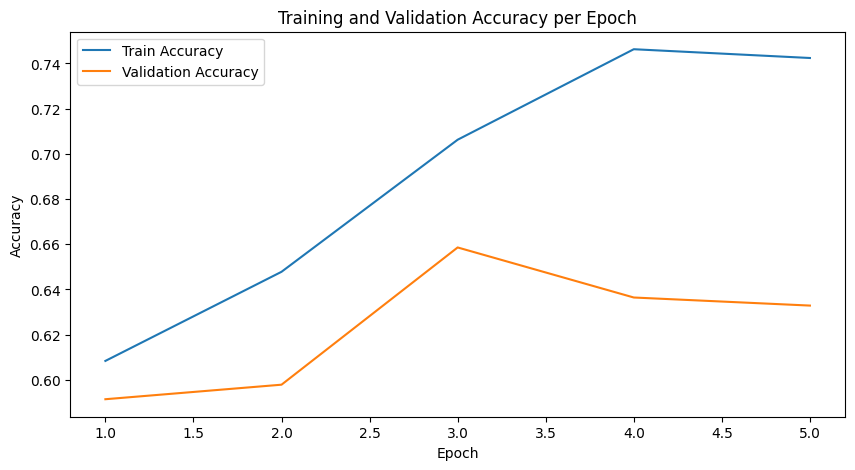

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, label='Train Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend()
plt.show()

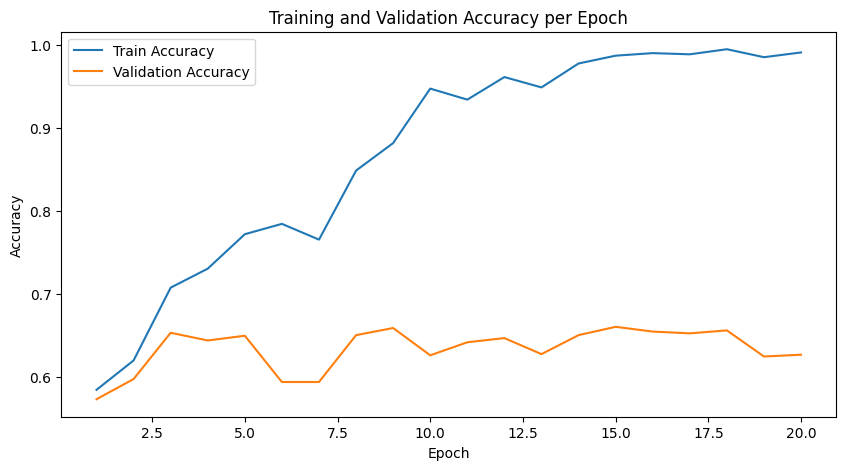

In [9]:
# Model, Loss Function, and Optimizer
model = StackedModel()


# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Call the train function
train_accuracy, val_accuracy, epochs = train(model, train_set, valid_set, batch_size=64, num_epochs=20, lr=0.001)

# Save the model
torch.save(model.state_dict(), 'stacked_model_64_20_0.001.pth')

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, label='Train Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend()
plt.show()

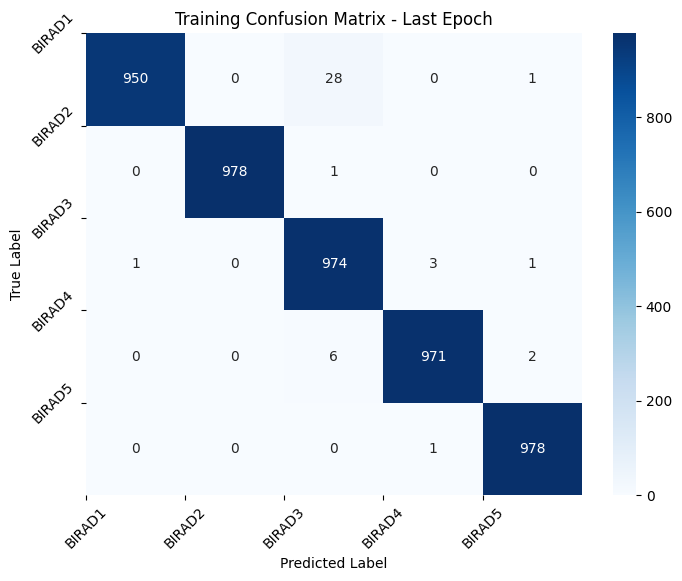

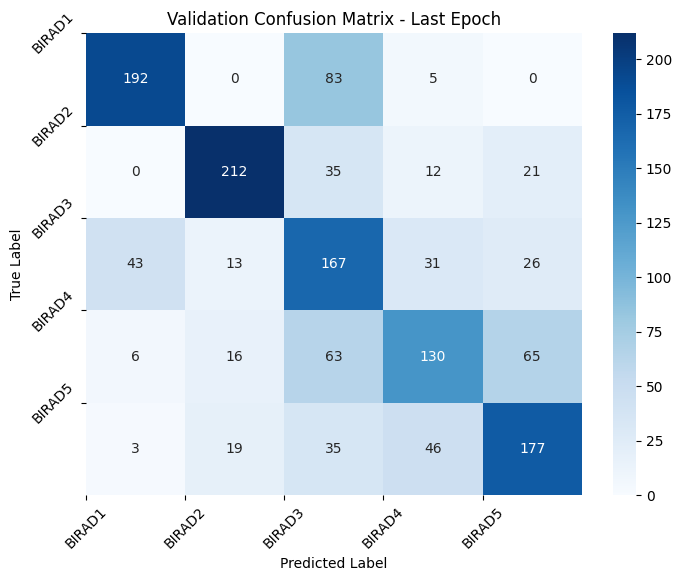

In [13]:
train_confusion_matrices = np.load('c:\\Users\\alanf\\Desktop\\aps360project\\train_confusion_matrices.npy')
val_confusion_matrices = np.load('c:\\Users\\alanf\\Desktop\\aps360project\\val_confusion_matrices.npy')
class_names = ['BIRAD1','BIRAD2','BIRAD3','BIRAD4','BIRAD5']
plot_last_confusion_matrix(train_confusion_matrices[-1], class_names, set_title='Training Confusion Matrix')
plot_last_confusion_matrix(val_confusion_matrices[-1], class_names, set_title='Validation Confusion Matrix')

c:\Users\alanf\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alanf\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\alanf\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights

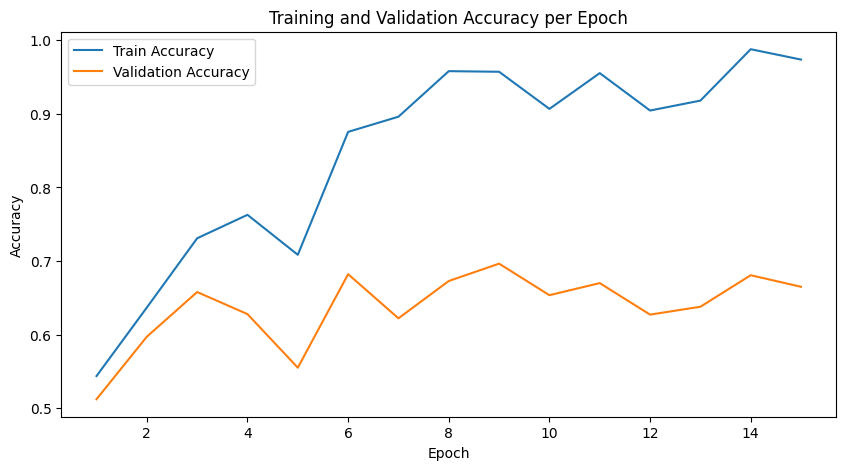

In [12]:
# Model, Loss Function, and Optimizer
model = StackedModel()


# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Call the train function
train_accuracy, val_accuracy, epochs = train(model, train_set, valid_set, batch_size=64, num_epochs=15, lr=0.0005)

# Save the model
torch.save(model.state_dict(), 'stacked_model_64_15_0.0005.pth')

[0.5436159346271706, 0.6367722165474975, 0.730949948927477, 0.7628192032686415, 0.7084780388151175, 0.8755873340143003, 0.896220633299285, 0.958120531154239, 0.9573033707865168, 0.9068437180796731, 0.9554647599591419, 0.9045965270684372, 0.9180796731358529, 0.987946884576098, 0.9738508682328907]
[0.5521428571428572, 0.6371428571428572, 0.6978571428571428, 0.6678571428571429, 0.5950000000000001, 0.7221428571428572, 0.6621428571428571, 0.7128571428571429, 0.7364285714285714, 0.6935714285714286, 0.7100000000000001, 0.6671428571428571, 0.6778571428571429, 0.7207142857142858, 0.7050000000000001]


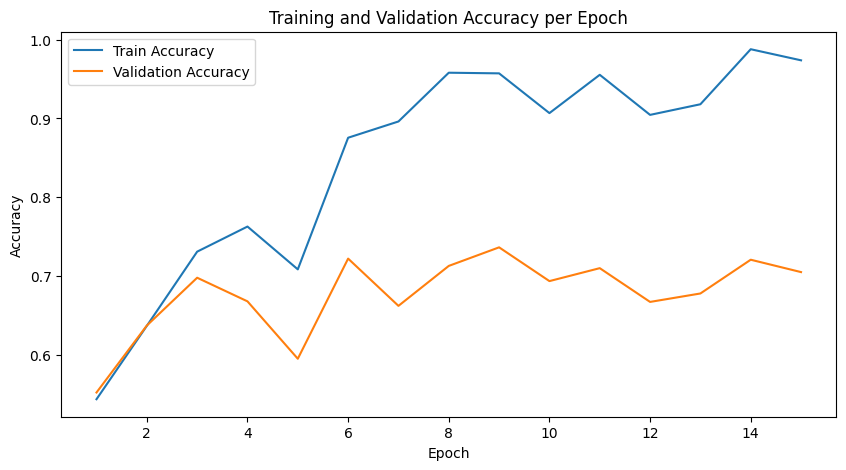

In [24]:
print(train_accuracy)
print(val_accuracy)
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, label='Train Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend()
plt.show()

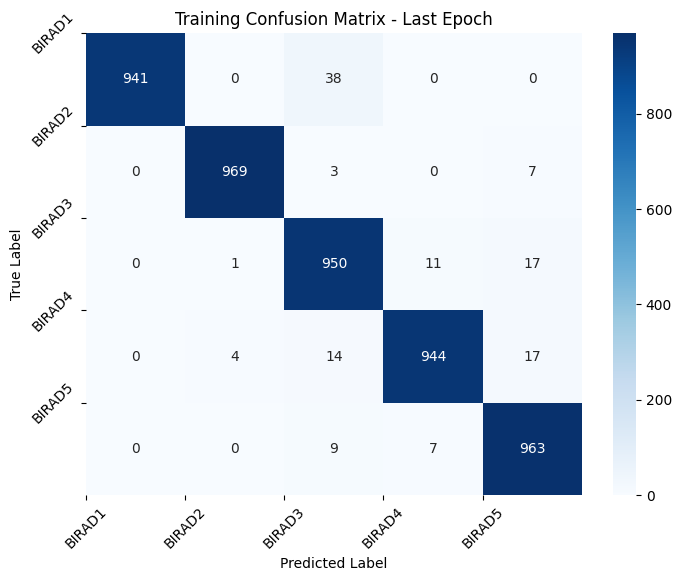

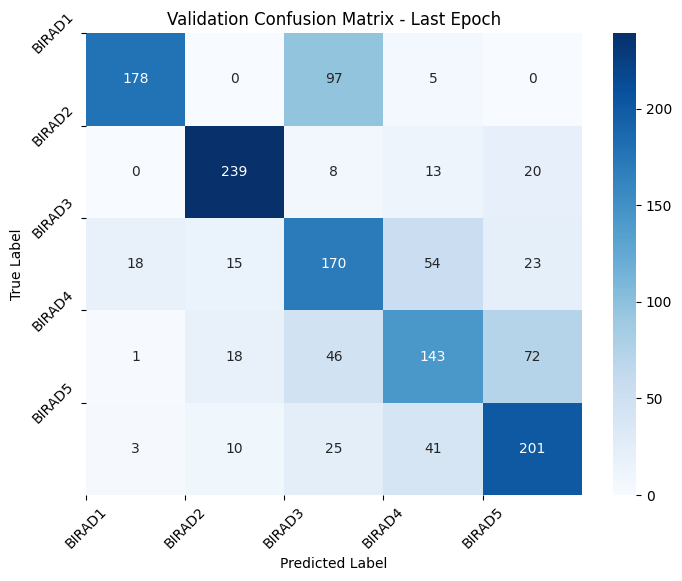

In [29]:
train_confusion_matrices = np.load('c:\\Users\\alanf\\Desktop\\aps360project\\train_confusion_matrices.npy')
val_confusion_matrices = np.load('c:\\Users\\alanf\\Desktop\\aps360project\\val_confusion_matrices.npy')
class_names = ['BIRAD1','BIRAD2','BIRAD3','BIRAD4','BIRAD5']
plot_last_confusion_matrix(train_confusion_matrices[-1], class_names, set_title='Training Confusion Matrix')
plot_last_confusion_matrix(val_confusion_matrices[-1], class_names, set_title='Validation Confusion Matrix')

# Evaluate on test Data

In [14]:
model = StackedModel()  # Assuming StackedModel is your model class
model.load_state_dict(torch.load('stacked_model_64_20_0.001.pth'))
model.to(device)  # Move to the appropriate device (e.g., 'cuda' if using GPU)
model.eval()  # Set the model to evaluation mode
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)
def evaluate(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# Evaluate the model
predictions, labels = evaluate(model, test_loader, device)


c:\Users\alanf\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alanf\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\alanf\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights

Test Accuracy: 0.6382978723404256
Confusion Matrix:
 [[103   0  35   1   2]
 [  0 107  15   5  14]
 [ 23   2  76  20  20]
 [  8   6  23  80  24]
 [  2   8  21  26  84]]


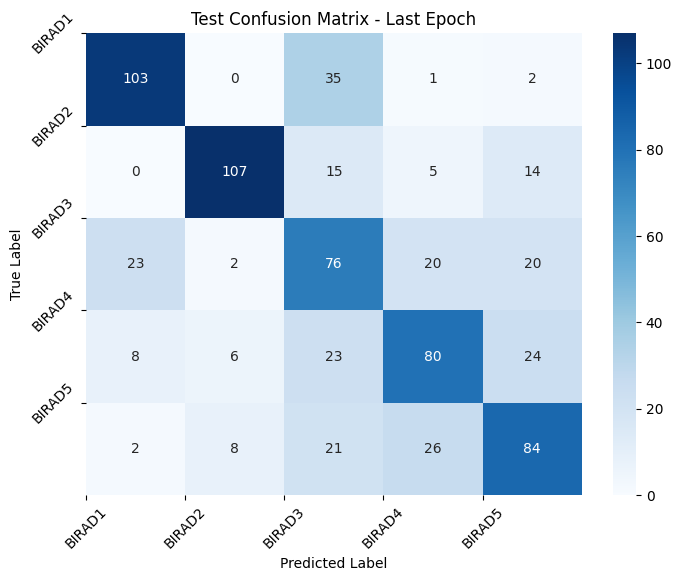

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy = accuracy_score(labels, predictions)
cm = confusion_matrix(labels, predictions)

print(f"Test Accuracy: {accuracy}")
print("Confusion Matrix:\n", cm)
plot_last_confusion_matrix(cm, class_names, set_title='Test Confusion Matrix')

In [25]:
model = StackedModel()  # Assuming StackedModel is your model class
model.load_state_dict(torch.load('stacked_model_64_15_0.0005.pth'))
model.to(device)  # Move to the appropriate device (e.g., 'cuda' if using GPU)
model.eval()  # Set the model to evaluation mode
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])


test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)
def evaluate(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# Evaluate the model

c:\Users\alanf\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alanf\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\alanf\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights

Test Accuracy: 0.6581560283687943


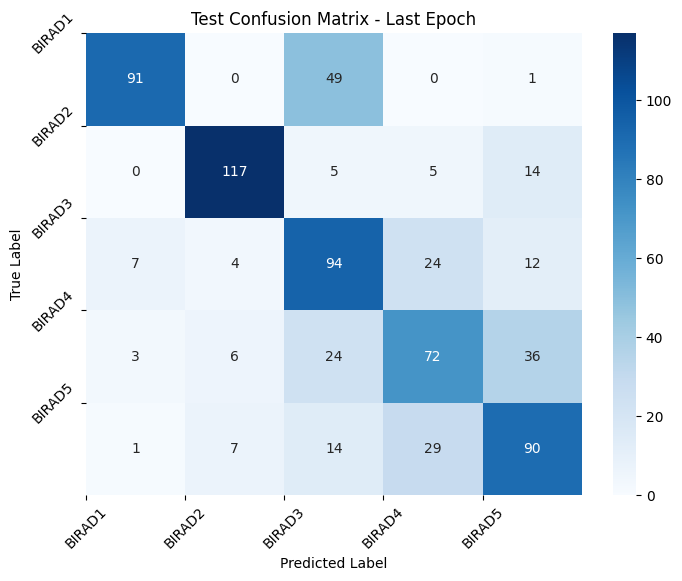

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix
predictions, labels = evaluate(model, test_loader, device)
accuracy = accuracy_score(labels, predictions)
cm = confusion_matrix(labels, predictions)

print(f"Test Accuracy: {accuracy}")
plot_last_confusion_matrix(cm, class_names, set_title='Test Confusion Matrix')

# Evaluate on New Data


In [33]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,std=std)])
test_path_final = 'c:\\Users\\alanf\\Desktop\\aps360project\\TestFinal'
test_set_final = torchvision.datasets.ImageFolder(root = test_path_final, transform = transform)

In [42]:
model = StackedModel()  # Assuming StackedModel is your model class
model.load_state_dict(torch.load('stacked_model_64_15_0.0005.pth'))
model.to(device)  # Move to the appropriate device (e.g., 'cuda' if using GPU)
model.eval()  # Set the model to evaluation mode


test_loader = torch.utils.data.DataLoader(test_set_final, batch_size=1, shuffle=True)
def evaluate(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

c:\Users\alanf\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alanf\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\alanf\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights

In [44]:
predictions, labels = evaluate(model, test_loader, device)
accuracy = accuracy_score(labels, predictions)
print(f"Test Accuracy: {accuracy}")


Test Accuracy: 0.6100840336134454
